In [2]:
import torch
import torch.nn as nn
import numpy as np
import numpy.random as rng
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [4]:
X = np.load('X.npy')
normalize_c = np.load('normalize_constant.npy')
train_losses = np.load('train_losses.npy')
val_losses = np.load('val_losses.npy')

In [5]:
normalize_c

array(567.64196324)

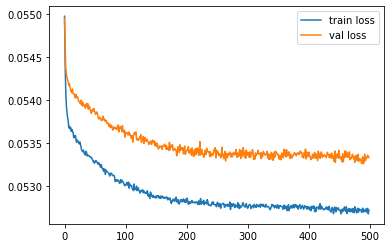

In [7]:
plt.plot(range(train_losses.shape[0]), train_losses)
plt.plot(range(train_losses.shape[0]), val_losses)
plt.legend(['train loss', 'val loss'], loc="upper right")
plt.show()

In [8]:
class MLP(nn.Module):
    def __init__(self, N, p):
        super(MLP, self).__init__()

        self.fc1 = nn.Linear(N, 1024)
        self.fc2 = nn.Linear(1024, 2048)
        self.fc3 = nn.Linear(2048, 2048)
        self.fc4 = nn.Linear(2048, 1024)
        self.fc5 = nn.Linear(1024, p)
        self.relu = nn.ReLU()
        self.mseloss = nn.MSELoss()
        self.bceloss = nn.BCEWithLogitsLoss()

    def forward(self, input):
        u = self.relu(self.fc1(input))
        u = self.relu(self.fc2(u))
        u = self.relu(self.fc3(u))
        u = self.relu(self.fc4(u))
        output = self.fc5(u)
        return output

    def get_mseloss(self, data, targ):
        output = self.forward(data)
        loss = self.mseloss(output, targ)
        return loss

    def get_bceloss(self, data, targ):
        output = self.forward(data)
        loss = self.bceloss(output, targ)
        return loss

In [9]:
md = MLP(1100, 1000)
md.load_state_dict(torch.load("My_model.pt"))

<All keys matched successfully>

In [31]:
true_beta = np.zeros((1000,1))
true_beta[:20,0]=2

In [33]:
Y_obs = X @ true_beta + rng.randn(100, 1)
input = np.concatenate((Y_obs, X.T @ Y_obs), axis=0) / normalize_c

In [23]:
md.eval()

MLP(
  (fc1): Linear(in_features=1100, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=2048, bias=True)
  (fc3): Linear(in_features=2048, out_features=2048, bias=True)
  (fc4): Linear(in_features=2048, out_features=1024, bias=True)
  (fc5): Linear(in_features=1024, out_features=1000, bias=True)
  (relu): ReLU()
  (mseloss): MSELoss()
  (bceloss): BCEWithLogitsLoss()
)

In [34]:
input = torch.from_numpy(input.reshape(-1)).type(torch.float)
md(input)

tensor([ 2.3497e-01,  3.2006e-01,  2.5131e-01,  2.5065e-01,  2.5891e-01,
         2.0150e-01,  8.7933e-02,  3.1552e-01,  1.4118e-01,  2.7010e-01,
         4.0263e-01,  2.1071e-01,  2.2476e-01,  2.6363e-01,  2.0602e-01,
         2.3139e-01,  1.0463e-02,  1.6265e-01,  1.4837e-01,  9.6440e-02,
        -2.4549e-02, -1.0608e-01,  2.7224e-02,  2.0846e-03,  2.7278e-02,
        -7.0330e-02,  1.4183e-02,  1.3784e-01, -4.3852e-03, -8.1029e-02,
         4.0207e-02,  4.3068e-02, -4.6469e-02,  2.2142e-01,  8.8808e-02,
        -4.1039e-02,  2.2250e-02,  7.4135e-02, -5.2712e-02,  2.0278e-02,
         9.3340e-02,  1.4753e-01,  1.4586e-02,  2.2460e-01,  8.4621e-02,
        -1.3086e-01, -3.0438e-02, -7.3100e-02, -7.4548e-02,  1.0810e-01,
         8.8635e-02,  6.1810e-02,  9.6820e-02, -4.8920e-02, -7.9199e-02,
        -5.6537e-02, -7.8304e-02, -2.0728e-01,  5.8444e-02, -6.6084e-02,
        -3.9849e-02, -3.9598e-02,  9.1954e-02,  5.5210e-02,  8.8892e-03,
        -2.0380e-02,  1.0648e-01,  2.3981e-02,  3.5

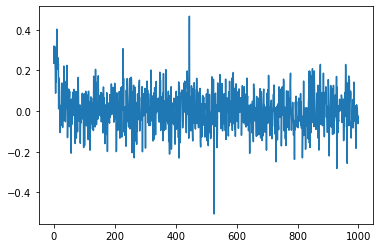

In [35]:
output = md(input).detach().numpy()
plt.plot(output)
plt.show()